In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.2.0'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Web_Sales']

time_col = 'date'
target_col = 'type_a'
lags = 30
n = 30
device = 'cpu'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])

In [5]:
valid_data = init_data.iloc[-lags:, :]
data = init_data.iloc[:-lags, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (2059, 2) , valid data shape:  (30, 2)


,date,type_a
2054,2021-08-10,9261
2055,2021-08-11,8976
2056,2021-08-12,8850
2057,2021-08-13,8731
2058,2021-08-14,7862


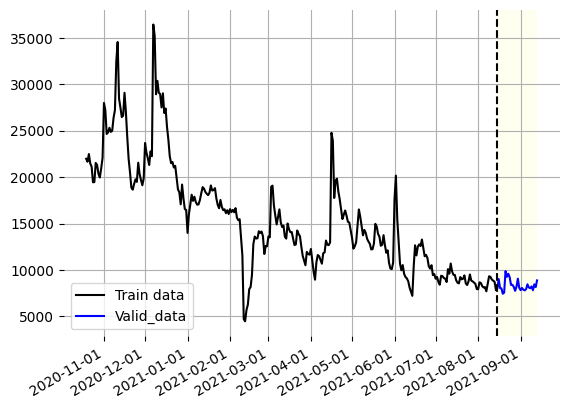

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-300:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data']
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import PipelineTS, PipelineConfigs

In [8]:
# list all models
PipelineTS.list_models()

['prophet',
 'auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest']

In [9]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pipeline_configs = PipelineConfigs([
    ('lightgbm', {'init_configs': {'verbose': -1}}),
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    ('multi_output_model', {
        'init_configs': {'estimator': XGBRegressor, 'random_state': 42, 'kwargs':{'verbosity':0}}
        }
    ),
    ('multi_output_model', {
        'init_configs': {'estimator': CatBoostRegressor, 'random_state': 42, 'verbose': False}
        }
    ),
])

,model_name,model_name_with_index,model_configs
0,lightgbm,lightgbm_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
2,multi_output_model,multi_output_model_2,"{'init_configs': {'estimator': <class 'xgboost.sklearn.XGBRegressor'>, 'random_state': 42, 'kwargs': {'verbosity': 0}}, 'fit_configs': {}, 'predict_configs': {}}"
3,multi_output_model,multi_output_model_3,"{'init_configs': {'estimator': <class 'catboost.core.CatBoostRegressor'>, 'random_state': 42, 'verbose': False}, 'fit_configs': {}, 'predict_configs': {}}"
4,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


In [10]:
from sklearn.metrics import mean_absolute_error
pipeline = PipelineTS(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    # models=['stacking_rnn'],  # specifying the model used
    device=device
)

In [11]:
pipeline.fit(data, valid_data=valid_data)

15:06:45 2023-10-11 - PipelineTS - There are a total of 21 models to be trained.
15:06:45 2023-10-11 - PipelineTS - [model  0] fitting and evaluating auto_arima...
15:08:21 2023-10-11 - PipelineTS - [model  1] fitting and evaluating catboost...
15:09:01 2023-10-11 - PipelineTS - [model  2] fitting and evaluating d_linear...
15:09:18 2023-10-11 - PipelineTS - [model  3] fitting and evaluating gau...
15:13:17 2023-10-11 - PipelineTS - [model  4] fitting and evaluating lightgbm_1...
15:13:31 2023-10-11 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
15:13:44 2023-10-11 - PipelineTS - [model  6] fitting and evaluating multi_output_model_2...
15:13:52 2023-10-11 - PipelineTS - [model  7] fitting and evaluating multi_output_model_3...
15:14:36 2023-10-11 - PipelineTS - [model  8] fitting and evaluating multi_step_model_1...
15:14:37 2023-10-11 - PipelineTS - [model  9] fitting and evaluating n_beats...
15:15:10 2023-10-11 - PipelineTS - [model 10] fitting and evaluat

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,auto_arima,96.177089,0.007294,450.038614
1,n_beats,32.933662,0.009357,753.716813
2,random_forest,4.491950,0.003276,790.574655
3,multi_output_model_2,8.096111,0.008766,796.223463
4,wide_gbrt,37.411619,0.010271,892.112540
5,multi_output_model_3,43.992002,0.011475,1216.259589
6,n_hits,59.587177,0.009501,1344.893099
7,lightgbm_1,13.954615,0.012955,1396.929496
8,stacking_rnn,662.624487,0.002053,1414.918735
9,multi_output_model_1,13.614770,0.011885,1509.258124


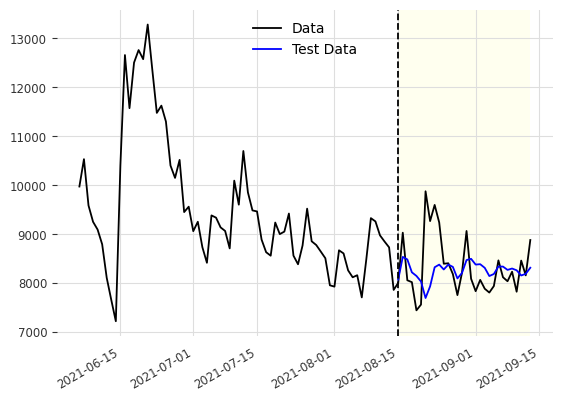

In [12]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [ ]:
# Gets all configurations for the specified model
pipeline.get_models('auto_arima').all_configs

## quantile prediction

In [13]:
from sklearn.metrics import mean_absolute_error

from PipelineTS.pipeline import PipelineTS

pipeline2 = PipelineTS(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,
    with_quantile_prediction=True,   # turn on the quantile prediction switch
    device=device
)

In [ ]:
pipeline2.fit(data, valid_data)

15:44:16 2023-10-11 - PipelineTS - There are a total of 21 models to be trained.
15:44:16 2023-10-11 - PipelineTS - [model  0] fitting and evaluating auto_arima...
15:47:44 2023-10-11 - PipelineTS - [model  1] fitting and evaluating catboost...
15:51:19 2023-10-11 - PipelineTS - [model  2] fitting and evaluating d_linear...
15:52:10 2023-10-11 - PipelineTS - [model  3] fitting and evaluating gau...
16:15:31 2023-10-11 - PipelineTS - [model  4] fitting and evaluating lightgbm_1...
16:17:08 2023-10-11 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
16:19:07 2023-10-11 - PipelineTS - [model  6] fitting and evaluating multi_output_model_2...
16:20:05 2023-10-11 - PipelineTS - [model  7] fitting and evaluating multi_output_model_3...
16:24:00 2023-10-11 - PipelineTS - [model  8] fitting and evaluating multi_step_model_1...
16:24:03 2023-10-11 - PipelineTS - [model  9] fitting and evaluating n_beats...
16:25:59 2023-10-11 - PipelineTS - [model 10] fitting and evaluat

In [ ]:
prediction = pipeline2.predict(n, 'n_beats')

plot_data_period(init_data.iloc[-30:, :], prediction, 
                 time_col=time_col, target_col=target_col)